# Supporting Information

This supporting information collects specific examples of generative BigSMILES as illustration of how a specific polymer ensemble might be constructed. This is an interactive Jupyter-Notebook and generates visual representations of the polymeric ensembles automatically with the [reference implementation](https://github.com/InnocentBug/bigSMILESgen) of generative BigSMILES. As visual representations of polymers can be challenging for long chain molecules, we typically limit ourselves to 

## Boiler plate code for visualization
This section can be safely ignored as it features python code, that converts generative BigSMILES into Jupyter Notebook visualizations. It can serve as a reference of how the reference implementation can be used.

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import pydot

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import bigsmiles_gen
from bigsmiles_gen import System, mol_prob, Molecule, System

# Consistent random numbers also across calls
rng = np.random.default_rng(42)


def render_svg(svg):
    """Render SVG images in the Notebook"""
    try:
        svg_string = svg.decode("utf-8")
    except AttributeError:
        svg_string = svg
    svg_string = svg_string.replace("svg:", "")
    return SVG(svg_string)


def moltosvg(mol, molSize=(450, 150), kekulize=True):
    """Generate a SVG stick representation of molecule."""
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg


def draw_molecule(molecule_string):
    global rng
    # Generate the abstract python object, parsing bigSMILES
    # Try it as a system first
    bigSMILESmol = System(molecule_string)
    mol = bigSMILESmol.generate(rng=rng)
    return render_svg(moltosvg(mol.get_mol()))


def draw_generation_graph(molecule_string):
    bigSMILESmol = Molecule(molecule_string)
    graph = bigSMILESmol.gen_reaction_graph()
    graph_dot = bigsmiles_gen.reaction_graph_to_dot_string(graph, bigSMILESmol)
    pydot_graph = pydot.graph_from_dot_data(graph_dot)[0]
    graph_svg = pydot_graph.create_svg()
    return render_svg(graph_svg)

## PS and PMMA

PS and PMMA are two well known and understood polymers. We use them here as a test bed to visualize different concepts of how a generative BigSMILES can be used to realize different ensembles.

But first, here is the regular BigSMILES with PS and PMMA repeat units.
`CCC(C){[>][<]CC([>])c1ccccc1[<], [>][<]CC([>])C(=O)OC [<]}[H]`
We note, that this would commonly be considered the representation of the random copolymer PS-r-PMMA.
Technically, this BigSMILES labels all the following examples, and we show how generative BigSMILES can be used to separate different polymer ensembles.

### PS-r-PMMA with molecular weight distribution

This first step is to narrow down the molecular weight distribution, we use the Schulz-Zimm distribution here as an illustrative example with the low molecular weight $M_w = 1500$ and $M_n=1400$. 

In [2]:
generative_bigSMILES = (
    "CCC(C){[>][<]CC([>])c1ccccc1, [<]CC([>])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[H]"
)

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


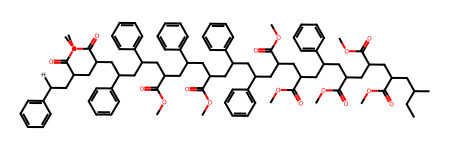

In [3]:
draw_molecule(generative_bigSMILES)

The generative graph for this ensemble looks like this:

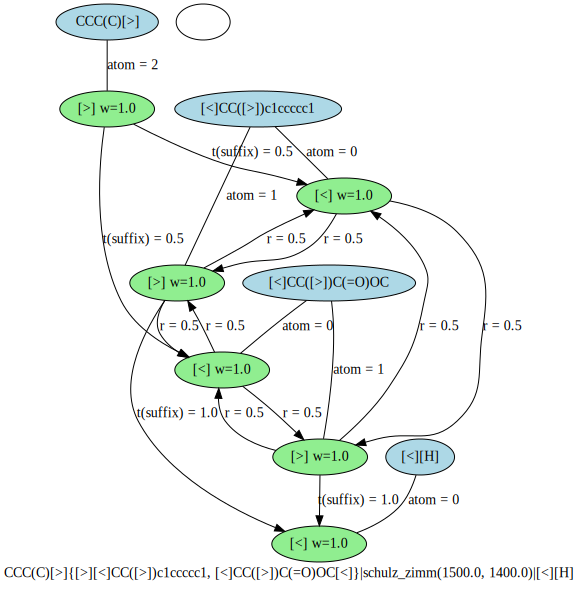

In [4]:
draw_generation_graph(generative_bigSMILES)

Both from the generated  molecule and the generating graph it is clear that we have equal probability of PS and PMMA in this ensemble. The next step is to change this composition via the bond descriptor weights.

### PS-r-PMMA with a 80:20 ratio

We can control the composition of PS and PMMA by assigning weights to the bond descriptors.

In [5]:
generative_bigSMILES = (
    "CCC(C){[>][<|8|]CC([>|8|])c1ccccc1, [<|2|]CC([>|2|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[H]"
)

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


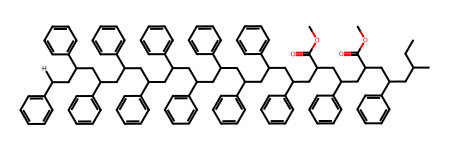

In [6]:
draw_molecule(generative_bigSMILES)

It is very clear that he majority of monomers is now PS and just a minority is PMMA.
This also becomes clear as we check the generation graph for this situation. Notice how the transition rates `r` change for the transitions between the bond descriptors belonging to the two monomers.

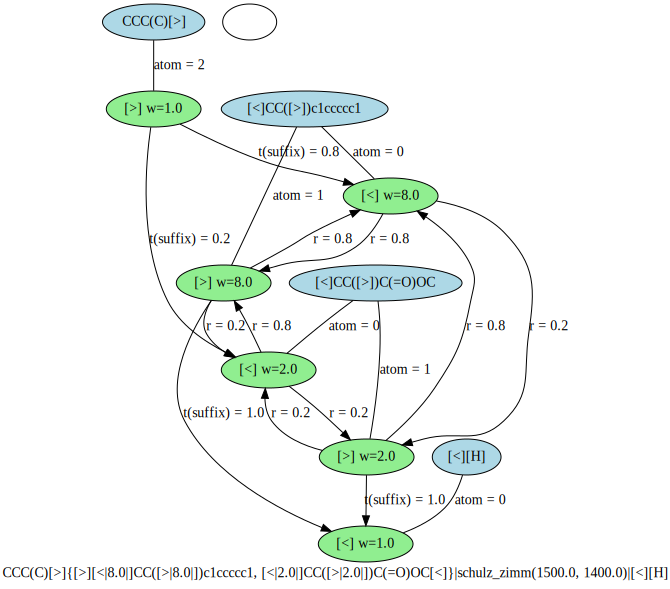

In [7]:
draw_generation_graph(generative_bigSMILES)

### PS-r-PMMA 70% blockiness 50:50 ratio

In the previous example we only described the ratio between PS and PMMA, but we left the blockiness, i.e. the likelihood that PS is followed by another PS and vice-versa for PMMA, unspecified. Now we are addressing this. Using the list weight notation of the generative bigSMILES we can specify the reaction probabilities of PS with PS and PMMA with PMMA.

As an example we choose for now that the probability for PS -> PS is 70% and PMMA -> PMMA is also 70%, which results in a significantly blockier random copolymer. We achieve this by assigned a 7 and 3 weight to represpective transition between the monomers.

In [8]:
generative_bigSMILES = "CCC(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 3 0 7|]CC([>|3 0 7 0|])C(=O)OC [<]}|schulz_zimm(5500, 5400)|[H]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


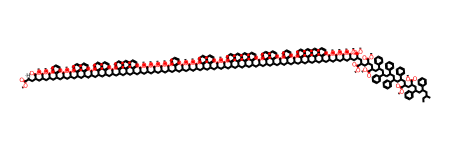

In [9]:
draw_molecule(generative_bigSMILES)

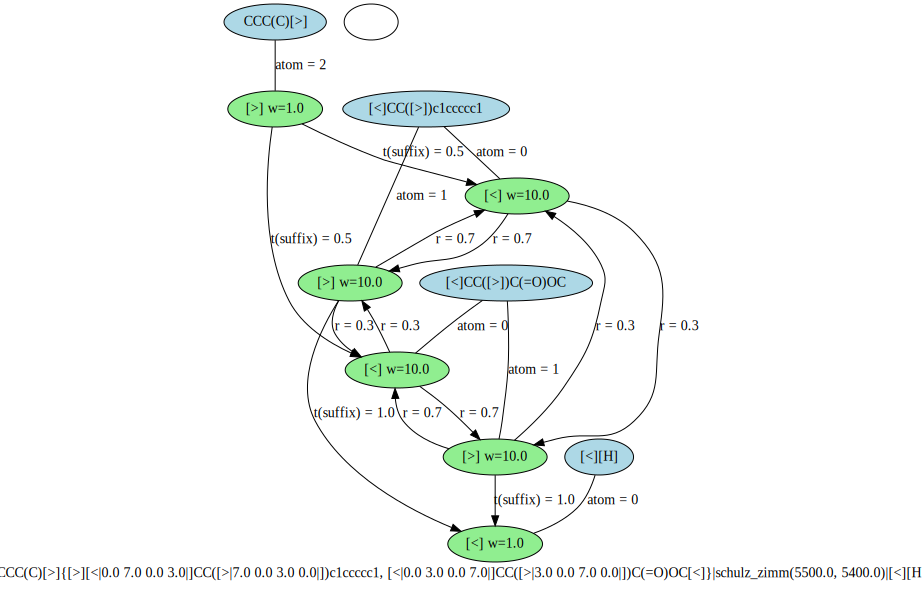

In [10]:
draw_generation_graph(generative_bigSMILES)

In the generative graph, this shift in probability to stay within the same block versus transitioning into a new block becomes visible too.

### PS-r-PMMA 70-60% blockiness 50:50 ratio


Notice that since the probability to transistion rate into the other block is 30% for both blocks in the previous example we automatically gain back a ratio between the two monomers of 50%.
But we can control this further, by changing the blockiness of the different blocks.

For this example we keep the 70% blockiness of PS, but change the PMMA blockiness to 20%.

In [11]:
generative_bigSMILES = "CCC(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 8 0 2|]CC([>|8 0 2 0|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[H]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


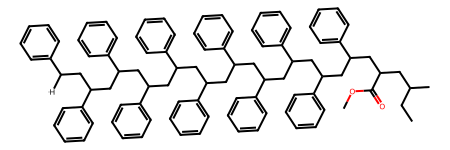

In [12]:
draw_molecule(generative_bigSMILES)

We can immediately observe, that PS is still blocky and just interrupted by a few less blocky PMMA monomers. We can determine the ratio between the monomers by comparing the probabilities to remain in the same block $p=20/70 \approx 0.286 $.

The generative graph reflects these transition probabilites as expected.

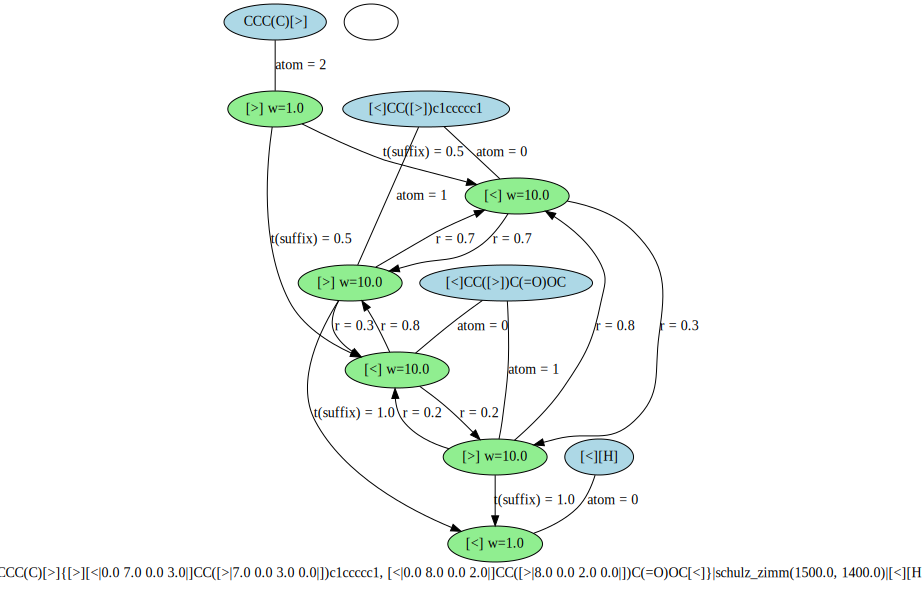

In [13]:
draw_generation_graph(generative_bigSMILES)

### PS-r-PMMA alternative sequence (least blocky)

One extreme case of blockiness is the an alternating sequence of monomers. This extreme case can be reflected with identies of bond descriptors in the regular BigSMILES. (still the original BigSMILES covers this case too.) This looks like this `CCC(C){[>2][<1]CC([>2])c1ccccc1, [<2]CC([>1])C(=O)OC ; [<1][H], [<2][H] []}` This specifies, that monomer are always only compatible with the other monomer, not with itself. This results in an alternating sequence.
Notice how we have to use stochastic end groups with both bond descriptor ids now. This is necessary since the molecule can end in a PS or PMMA and we need to be able to terminate both. This is a significant limitation, since continuing the molecule after the stochastic object is not possible. This notation also requires us to pick either PS or PMMA to be connected to the prefix initiator. (here we it is PMMA)

This can exactly be mimicked in generative bigSMILES.

In [14]:
generative_bigSMILES = "CCC(C){[>2][<1]CC([>2])c1ccccc1, [<2]CC([>1])C(=O)OC ; [<1][H], [<2][H] []}|schulz_zimm(1500, 1400)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


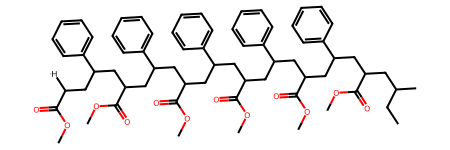

In [15]:
draw_molecule(generative_bigSMILES)

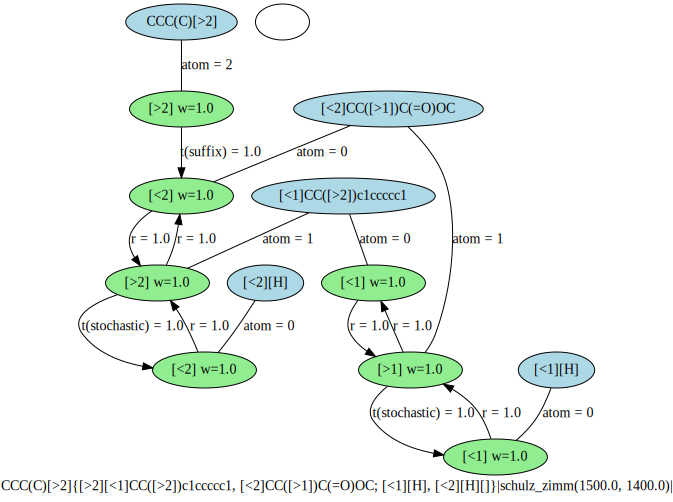

In [16]:
draw_generation_graph(generative_bigSMILES)

We can see in the generation graph how only connections between unlike monomers are allowed.

In generative BigSMILES we can overcome the limitation of using stochastic eng groups by specifying listed bond weights insted. This way we generally leave all bond descriptors compatible, but instead define 0 transition probabilities for unwanted connections.

In [17]:
generative_bigSMILES = "CCC(C){[>][<|0 0 0 1|]CC([>|0 0 1 0|])c1ccccc1, [<|0 1 0 0|]CC([>|1 0 0 0|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[H]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


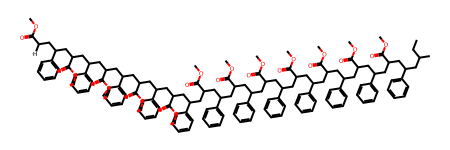

In [18]:
draw_molecule(generative_bigSMILES)

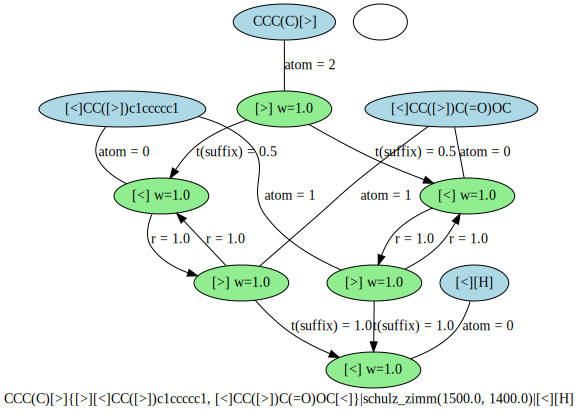

In [19]:
draw_generation_graph(generative_bigSMILES)

We can see that this results in the same molecule ensemble, but allows the continuation as it doesn't require stochastic end groups.

### PS-b-PMMA diblock-copolymer

The other extreme of blockiness is the diblock copolymer. Again the inital BigSMILES notation is also correct for diblock copolymes, but a better notation is available using two connected stochastic objects: `CCC(C){[>][<]CC([>])c1ccccc1 [<]}{[>][<]CC([>])C(=O)OC[<]}[H]`

And this can be reflected in the exact same notation for generative BigSMILES as well.

In [20]:
generative_bigSMILES = "CCC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(1000,900)|{[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(1000, 900)|[H]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


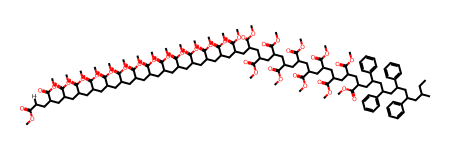

In [21]:
draw_molecule(generative_bigSMILES)

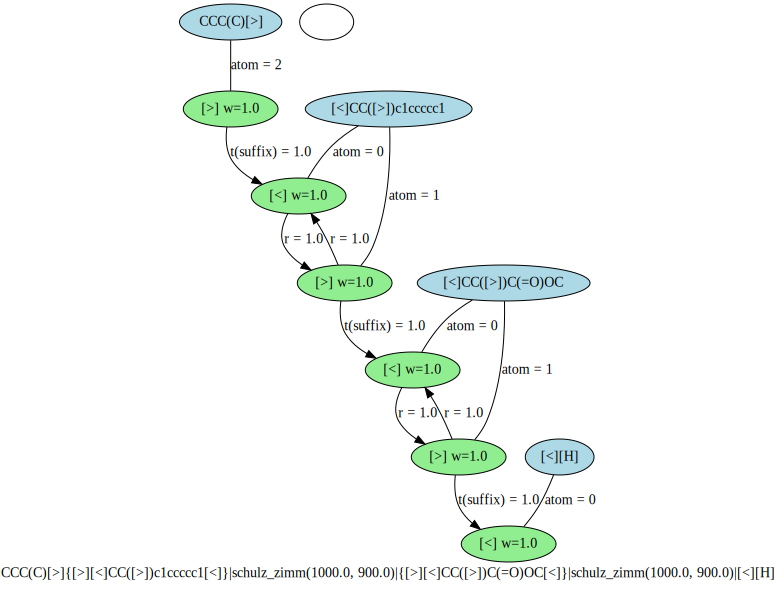

In [22]:
draw_generation_graph(generative_bigSMILES)

In the BigSMILES notation the ratio between the two blocks remains unspecified. But with generative BigSMILES the size of the two blocks can be specified via the molecular weight specification of both stochastic object.

### PS PMMA mixtures

The initial BigSMILES notation also describes polymer ensembles of PS and PMMA homopolymers, and mixtures of the two. Although it is highly advised to not specify the homopolymers like this.

There is a variation of the BigSMILES that can be used to describe a mixture of PS and PMMA.


`{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1], CC(C)[>2], [<1][H], [<2][H][]}`

In this variation all bond descriptors between PS or PMMA are incompatible to one another. Consequently it is not possible to connect PS and PMMA monomers or end groups, so this uniquely indentifies a mixture of PS and PMMA homopolymers.
Still it is highly advised to not use this notation to indicate a mixture.

This same quirk in the notation can be used with the generative BigSMILES as well.

In [23]:
generative_bigSMILES = "{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1|2|], CC(C)[>2], [<1|2|][H], [<2][H][]}|schulz_zimm(700, 600)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


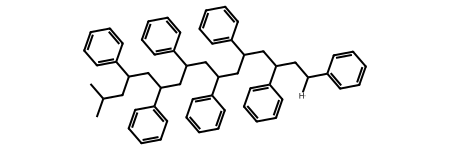

In [24]:
draw_molecule(generative_bigSMILES)

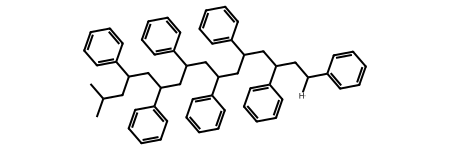

In [25]:
draw_molecule(generative_bigSMILES)

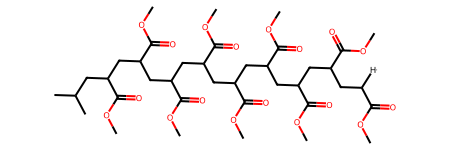

In [26]:
draw_molecule(generative_bigSMILES)

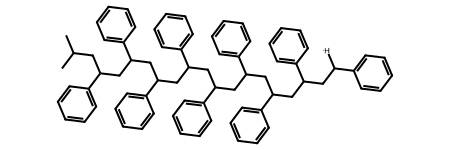

In [27]:
draw_molecule(generative_bigSMILES)

Notice, how the different homopolymers can be generated from a single BigSMILES. We we also used the weight of the end groups to achieve a 2:1 ration between PS and PMMA.

The generationg graph clearly shows how the two molecules are separate from one another.

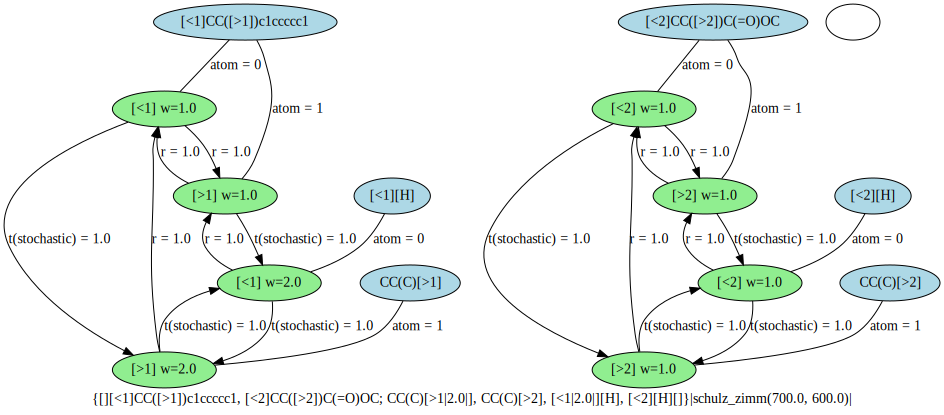

In [28]:
draw_generation_graph(generative_bigSMILES)

It is still not advised to use this notation to describe a mixture of the two homopolymers.

Instead, we can use the mixture notation of generative BigSMILES to describe a mixture.

In [29]:
generative_bigSMILES = "CC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(700, 600)|[H].|5000|CC(C){[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(700, 600)|[H].|33%|"

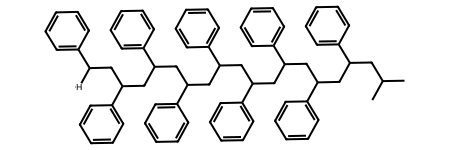

In [30]:
draw_molecule(generative_bigSMILES)

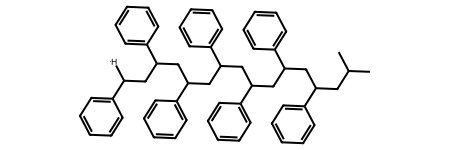

In [31]:
draw_molecule(generative_bigSMILES)

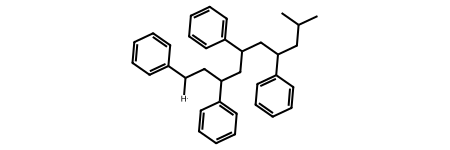

In [32]:
draw_molecule(generative_bigSMILES)

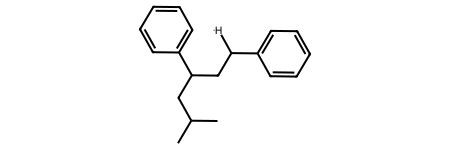

In [33]:
draw_molecule(generative_bigSMILES)

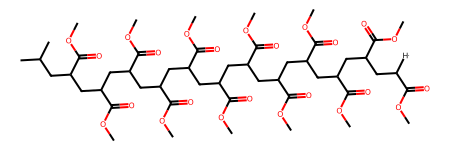

In [34]:
draw_molecule(generative_bigSMILES)

This notation allows a much more fine control over the mixture ensembles generated and also expressed the intent much more clearly and is strongly preferred over the single stochastic object notation for mixtures.

Note how this applies universally to mixtures like polymers in solution, even though we show here a mixture of two homopolymers.